# The Titanic Classification Challenge

RMS Titanic, the British passenger liner, sank on her maiden voyage after colliding with an iceberg.  On April 10, 1912, Titanic left the dock in Southampton, England for Cherbourg, France, and then proceeded to Queenstown (known as Cobh), Ireland. She began the voyage across the Atlantic on April 11, headed for New York.  On April 15, at 2:00 am, RMS Titanic sank. Of the 2224 passengers, 722 survived, while 1502 perished in the icy waters.

### The Titanic Data
The Titanic dataset from Kaggle.com provided a challenge in predicting which passengers would survive based on passenger demographics and ticketing information.  Fields included age, gender, ticket price (Fare), ticket class (Pclass), passenger ID, cabin number (Cabin), city of embarcation (Embarked), number of siblings and spouces (SibSp) and number of parents and children (Parch) onboard. 

In this project, a series of four classification models was produced to predict passenger survival (1) or not (0). Model performance was compared using the results of holdout validation (25%). 

### The Modeling Process
The modeling process included: 
 - Data Cleaning 
 - Feature Selection 
 - Feature Encoding 
 - Training and Fitting Models 
 - Reviewing Model Results  

### Function Definitions
Code functions were defined to aid reuse. Functions are typically saved into a .py file and imported.  However, they were placed in this file for ease of viewing.

In [1]:
#import Libraries
import sklearn as sk
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
#Show percentage & count of cells with 'Not Applicable' (NA) for each column
def view_na_percentage(datafrm):
    print('Missing Cells:')
    percentage = pd.Series(round((datafrm.isnull().sum()
        .sort_values(ascending=False))/len(datafrm)*100,1), name='Percentage') 
    count = pd.Series(datafrm.isna().sum(), name='Count')
    na_df = pd.concat([count, percentage], axis=1)
    print(na_df)
    return

In [3]:
#Remove duplicate rows
def view_and_remove_duplicates(datafrm):
    duplicate_rows_df = datafrm[datafrm.duplicated()]
    if duplicate_rows_df.size == 0:
        print("No duplicate rows found in dataset.")
    else:
        print("Duplicate rows removed (keep first occurrence): ")
        print(duplicate_rows_df)
        datafrm = datafrm.drop_duplicates(keep='first')
    return datafrm

In [4]:
#Create a median lookup table for a target column based on column groupings
def explore_with_group_table(datafrm, full_list):
    #grouping variables are at the front of list, target is at end of list  
    lookup_table = datafrm.groupby(full_list[:-1])[full_list[-1]].median().reset_index()[full_list]
    #if any NAs remain after grouping, use median of the entire target column
    a_median = datafrm[full_list[-1]].agg(['median'])
    lookup_table[full_list[-1]] = lookup_table.apply(lambda row: a_median 
                            if pd.isnull(row[full_list[-1]]) else row[full_list[-1]], axis=1)    
    print(lookup_table.to_string(index=False))
    return lookup_table

In [5]:
#Drop columns provided in a list
def drop_columns_for_dataset(datafrm, list_of_cols_to_drop):
    if set(list_of_cols_to_drop).issubset(datafrm.columns):
        datafrm.drop(list_of_cols_to_drop, axis=1, inplace=True)
    print(f'Data columns dropped: {", ".join(list_of_cols_to_drop)} ')
    return datafrm

In [6]:
#Drop rows with NAs if remaining dataset is larger than 500 rows
def drop_remaining_na_rows(datafrm):
    print(f'Before drop: row, col count: {datafrm.shape}')
    print(f"NA count: {round(datafrm.isnull().sum())}")
    len_after_drop =len(datafrm.dropna())
    if len_after_drop>500:
        datafrm = datafrm.dropna()
        print(f'After drop: row, col count: {datafrm.shape}')
    else:
        print('Rows with NAs not removed.')
    return datafrm

In [7]:
#Show correlations between response variable and numeric predictor variables
def analyze_num_variables(datafrm):
    print(f'Numeric Variables Description:\n{datafrm.describe().transpose()}\n')
    df_corr = datafrm.corr()
    print(f'Numeric Variables Correlation Matrix:\n{df_corr}')
    fig1, ax1 = plt.subplots(figsize=(12,10))
    print(f'\nCorrelation Heat Map:\n')
    sns.heatmap(df_corr, cmap="Blues", annot=True)   
    return

In [8]:
#Show crosstab for response and categorical variables, response var at the end
def analyze_cat_variables(datafrm, col_list):
    response_var = col_list[-1]
    for i, value in enumerate (col_list[:-1]):
        crosstab = pd.crosstab(datafrm[value], datafrm[response_var])
        print(f"\n{response_var} vs {col_list[i]}:\n{crosstab}\n")
        chi2, p, dof, ex  = stats.chi2_contingency(crosstab)
        print(f'Chi2 Test: {chi2}  p-value:{p}')                                     
    return

In [9]:
#Create binary encoding for categorical variables (drop_first sets ref variable)
def create_bin_encoded_vars(datafrm, category_col_list, drop=True):
    try:
        datafrm = pd.get_dummies(datafrm, columns=category_col_list, drop_first=drop)   
        print(f'Dataframe after encoding (drop-first: {drop}):\n{datafrm.head(5)}') 
    except:
        print('Encoding failed. Check columns.')
    return datafrm

In [10]:
#Save csv file
def save_file(datafrm, path, filenm):
    datafrm.to_csv(path + filenm, index=False)
    return

In [11]:
#Shuffle and call save file
def shuffle_and_save_file(datafrm, path, filenm):
    datafrm = datafrm.sample(frac=1).reset_index(drop=True)
    save_file(datafrm, path, filenm)
    return 

In [12]:
#Show dataframe attributes
def check_dataframe(datafrm): 
    print(f'Dataset shape: {datafrm.shape}\n')
    view_na_percentage(datafrm)
    print(f'\nDataset Columns:\n{datafrm.head(3)}\n')
    return

#End of reusable functions

## Data Cleaning
To prepare for modeling, the dataset was examined for duplicate rows and missing cell values. Additionally, variables were explored for the potential to contribute to the predictive model solution.  

In [13]:
#load titanic dataset
df1 = pd.read_csv('datasets/train_titanic.csv')
df1.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There were 11 possible predictor variables (PassengerId, Pclass, Name, Sex, Age, SibSp and Parch Ticket, Fare, Cabin, and Embarked) and one response variable (Survived). 

### Handle Duplicates

The dataset was checked for duplicate rows.  There were none. 

In [14]:
#remove duplicates
df1 = view_and_remove_duplicates(df1)

No duplicate rows found in dataset.


### Handle Missing Values

The dataset was checked for missing cells in each column.

In [15]:
#view missing data percentages
view_na_percentage(df1)

Missing Cells:
             Count  Percentage
PassengerId      0         0.0
Survived         0         0.0
Pclass           0         0.0
Name             0         0.0
Sex              0         0.0
Age            177        19.9
SibSp            0         0.0
Parch            0         0.0
Ticket           0         0.0
Fare             0         0.0
Cabin          687        77.1
Embarked         2         0.2


Due to the high number of NAs in the Cabin column, the column was a candidate to be dropped.  The Age column also contained more than the acceptable percentage (approximately 5%) of missing values.  It was reasonable that age may be beneficial to the model solution, since age is reasonable related to survival ability. So, age was examined further. For Embarked, there were two missing cells. These two cells were filled using the highest value from a frequency table in this initial model.

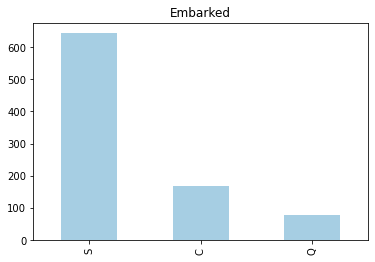

In [16]:
sns.set_palette("Paired")
df1['Embarked'].value_counts().plot(kind="bar", alpha=1.0, title='Embarked');

Since most passengers embarked at city S, Southhampton, this value was be placed in the two missing cells.

In [17]:
#fill rows with the highest frequency level when Embarked is null
df1['Embarked'] = df1.apply(lambda row:str('S') 
                            if pd.isnull(row['Embarked']) else row['Embarked'], axis=1)

In [18]:
#view missing data percentages
view_na_percentage(df1)

Missing Cells:
             Count  Percentage
PassengerId      0         0.0
Survived         0         0.0
Pclass           0         0.0
Name             0         0.0
Sex              0         0.0
Age            177        19.9
SibSp            0         0.0
Parch            0         0.0
Ticket           0         0.0
Fare             0         0.0
Cabin          687        77.1
Embarked         0         0.0


To fill the missing values in the Age column, a lookup table was built to find similar records, based on the groups of categorical variables (PClass, Sex). This is similar to KNN imputation.  A median age value for each group was used.   

In [19]:
#Build lookup table for median values for target var: Age, using category groups  
full_list = ['Pclass', 'Sex',  'Age']
lookup_df = explore_with_group_table(df1, full_list)

 Pclass     Sex   Age
      1  female  35.0
      1    male  40.0
      2  female  28.0
      2    male  30.0
      3  female  21.5
      3    male  25.0


The missing age values were filled with the median values from similar groups.

In [20]:
#Fill age using the lookup table above for median 'Age' for this data
def fill_age(row):
    age_value = lookup_df[(lookup_df['Pclass']==row.Pclass)&
                          (lookup_df['Sex']==row.Sex)]['Age'].values[0]
    return age_value

In [21]:
#call fill_age for missing cells
df1['Age']= df1.apply(lambda row: fill_age(row) if pd.isnull(row['Age']) 
                      else row['Age'], axis=1)

The dataset was checked for missing values after filling values.

In [22]:
#view missing data percentages
view_na_percentage(df1)

Missing Cells:
             Count  Percentage
PassengerId      0         0.0
Survived         0         0.0
Pclass           0         0.0
Name             0         0.0
Sex              0         0.0
Age              0         0.0
SibSp            0         0.0
Parch            0         0.0
Ticket           0         0.0
Fare             0         0.0
Cabin          687        77.1
Embarked         0         0.0


### Drop Arbitrary Data Columns

Seemingly arbitrary fields (Name, Ticket, and PassengerId) were dropped in this initial model.  While the Name and Cabin did contain some information that may be helpful, it was not used in this initial model. 

In [23]:
#drop rows that are arbitrary or contain NAs and cannot be handled at this time
drop_list = ['Cabin', 'Ticket', 'Name', 'PassengerId']
df1 = drop_columns_for_dataset(df1, drop_list)

Data columns dropped: Cabin, Ticket, Name, PassengerId 


### Unbalanced Response Variable Class Frequency
It was noted that the training dataset had more observations for Survived = 0, than for Survived = 1. For this reason, a stratified sampling method was considered for training/test set splits. Stratification aided in ensuring the appropriate number of observations for Survived = 1. 

Survived Level Counts: [549 342]
Survived Percentage: [61.6 38.4]


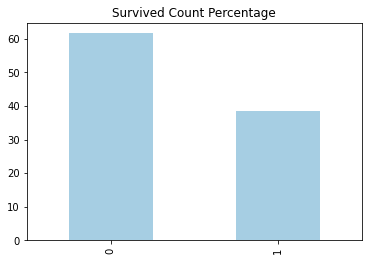

In [24]:
#show Survived level counts
sns.set_palette("Paired")
print(f'Survived Level Counts: {df1.Survived.value_counts().values}')
print(f'Survived Percentage: {np.round(((df1.Survived.value_counts().values)/(len(df1.index))*100),1)}')
(df1.Survived.value_counts()/len(df1.index)*100).plot(kind='bar', title="Survived Count Percentage");

## Feature Selection

### Feature Selection: Important Categorical Variables

Categorical variables were explored next. The ticket class (PClass) column, which held ordinal data, was handled as a categorical variable. Pclass, Embarked, and gender were examined for importance in predicting survival. Crosstabs were produced, chi square tests for category independence were performed, and visualizations were examined.

In [25]:
#Pclass is handled as categorical variable so change type to string
df1.loc[:,"Pclass"] = df1["Pclass"].astype(str)

In [26]:
#show crosstables for response variable 'Survived' (response var at end of list)
cat_var_col_list = ['Sex', 'Pclass', 'Embarked', 'Survived']
analyze_cat_variables(df1, cat_var_col_list)


Survived vs Sex:
Survived    0    1
Sex               
female     81  233
male      468  109

Chi2 Test: 260.71702016732104  p-value:1.1973570627755645e-58

Survived vs Pclass:
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

Chi2 Test: 102.88898875696056  p-value:4.549251711298793e-23

Survived vs Embarked:
Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  219

Chi2 Test: 25.964452881874784  p-value:2.3008626481449577e-06


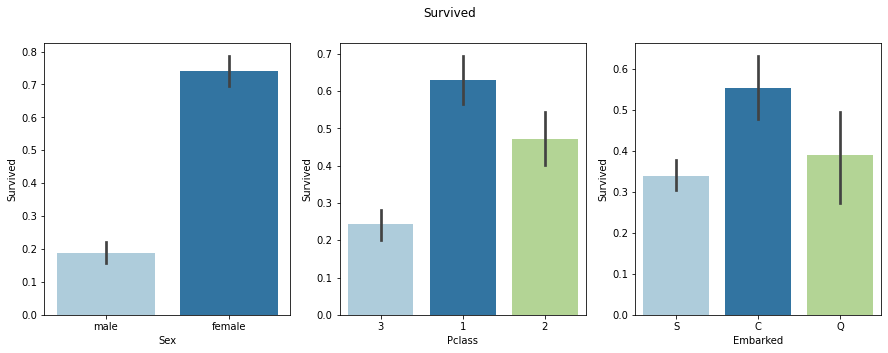

In [27]:
#draw bar charts 
response_var = 'Survived'
figure, axes = plt.subplots(1,3, figsize=(15,5))
figure.suptitle(response_var)
sns.set_palette("Paired")
sns.barplot(x='Sex', y=response_var , data=df1, ax=axes[0])
sns.barplot(x='Pclass', y=response_var , data=df1, ax=axes[1])
sns.barplot(x='Embarked', y=response_var , data=df1, ax=axes[2])
plt.show()

All chi-square tests for independence were significant, showing a relationship to Survived.  After examining the crosstabs, chi square p-values, and the bar charts, all of these categorical variables were deemed important to the prediction model. 

### Feature Selection: Important Numeric Variables

Next, the numeric variables (Age, SibSpm, Parch, and Fare) were examined for a relationship to survival. The categorical variable Pclass was encoded as numeric in order to examine it in a correlation matrix.  

In [28]:
#change type on Pclass to see correlations
df1.loc[:,"Pclass"] = df1["Pclass"].astype(int)

Numeric Variables Description:
          count       mean        std   min      25%      50%   75%       max
Survived  891.0   0.383838   0.486592  0.00   0.0000   0.0000   1.0    1.0000
Pclass    891.0   2.308642   0.836071  1.00   2.0000   3.0000   3.0    3.0000
Age       891.0  29.112424  13.304424  0.42  21.5000  26.0000  36.0   80.0000
SibSp     891.0   0.523008   1.102743  0.00   0.0000   0.0000   1.0    8.0000
Parch     891.0   0.381594   0.806057  0.00   0.0000   0.0000   0.0    6.0000
Fare      891.0  32.204208  49.693429  0.00   7.9104  14.4542  31.0  512.3292

Numeric Variables Correlation Matrix:
          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.338481 -0.059579 -0.035322  0.081629  0.257307
Pclass   -0.338481  1.000000 -0.413583  0.083081  0.018443 -0.549500
Age      -0.059579 -0.413583  1.000000 -0.249854 -0.175526  0.122692
SibSp    -0.035322  0.083081 -0.249854  1.000000  0.414838  0.159651
Parch     0.081629  0.018443 -0.175526 

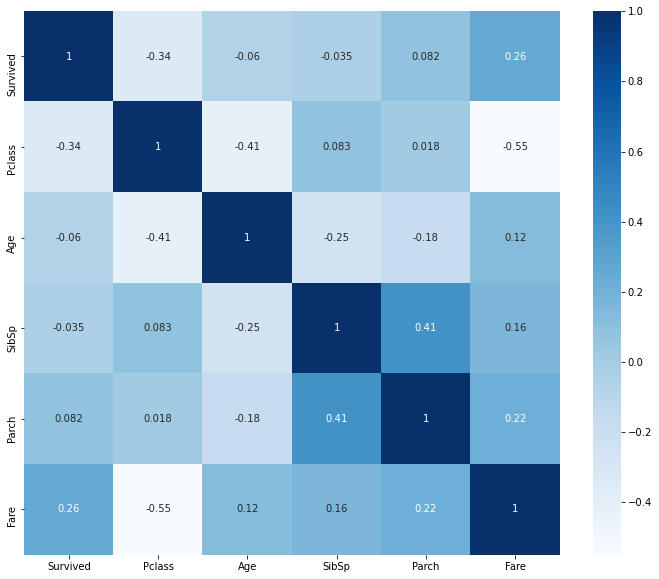

In [29]:
#analyze numeric variables
analyze_num_variables(df1)

After review of correlations and descriptive statistics, all of these variables remained in the model. There was a moderate correlation to Survived for: Fare, Pclass and Sex. There was a possibility of collinearity between Fare and Pclass. Since this was a prediction model and not an effect-size model, both variables remained in the model. Also, Age and Pclass showed a strong relationship.  While Age did not show a strong correlation to survival, it remained in this initial model due to reasoning that age may affect survival. 

## Feature Encoding

Categorical variables were binary-encoded with drop_first set to true, so that reference levels would be set to the first level.  

In [30]:
#change type on Pclass for binary encoding
df1.loc[:,"Pclass"] = df1["Pclass"].astype(str)

In [31]:
#peform binary encoding - check fields after encoding, use drop_first = True
category_col_list = ['Sex', 'Embarked', 'Pclass']
df1 = create_bin_encoded_vars(df1, category_col_list, True)

Dataframe after encoding (drop-first: True):
   Survived   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S  \
0         0  22.0      1      0   7.2500         1           0           1   
1         1  38.0      1      0  71.2833         0           0           0   
2         1  26.0      0      0   7.9250         0           0           1   
3         1  35.0      1      0  53.1000         0           0           1   
4         0  35.0      0      0   8.0500         1           0           1   

   Pclass_2  Pclass_3  
0         0         1  
1         0         0  
2         0         1  
3         0         0  
4         0         1  


### Shuffle Data and Save the Encoded File

In [32]:
#reindex and save encoded data file
shuffle_and_save_file(df1, 'datasets/', 'titanic_encoded.csv')

#Ready for modeling

## Train and Fit Models 

Four different classifiers were instantiated.  The four models were trained using the encoded dataset.  Validation was performed using holdout validation at 25% (default). Model results included accuracy, precision, and recall. 

### Define Functions for Reuse

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [34]:
#build dictionary for results
def build_accuracy_dict(y_test, y_predict):
    acc = accuracy_score(y_test, y_predict, normalize=True)
    prec = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    return{"Accuracy": acc, 
           "Precision": prec, 
           "Recall": recall}

In [35]:
#final results
def show_results_table(model_dict1):
    table = pd.DataFrame(columns = ['Model', 'Accuracy' , 'Precision' , "Recall"])
    #unpack to i and tuple
    for i, (key, value) in enumerate(model_dict1.items()):
        table.loc[i] = [key, 
                    round(value["accuracy_dict"]["Accuracy"],4),
                    round(value["accuracy_dict"]["Precision"],4),
                    round(value["accuracy_dict"]["Recall"],4)]
    print(table.sort_values(['Accuracy', 'Precision'], ascending=False).to_string(index=False))
    return

In [36]:
#split data set for holdout validation
def split_data(name_of_response, names_of_predictors, dataset, stratified, test_fraction=0.25):  
    #set predictors and response
    x_predictors = dataset[names_of_predictors]
    y_response = dataset[name_of_response]
    #set stratified option
    if(stratified):
        target = y_response
    else:
        target = None   
    #shuffle/split dataset for holdout and return 4 objs: x_train, x_test, y_train, y_test
    return train_test_split(x_predictors, y_response, stratify=target, test_size=test_fraction)

In [37]:
#Fit model and test against holdout: store results and show confusion matrix
def fit_assess_model(name, classifier_model, x_train, x_test, y_train, y_test):
    #fit the model to the training set
    fitted_model = classifier_model.fit(x_train, y_train)
    y_pred = fitted_model.predict(x_test)
    #collect and store accuracy data
    accuracy_dict = build_accuracy_dict(y_test, y_pred)
    truth_vs_pred_df = pd.DataFrame({'Truth': y_test, 
                                     'Predicted': y_pred})
    result_dict = {'accuracy_dict': accuracy_dict,
                   'truth_vs_predicted': truth_vs_pred_df}
    #show sklearn confusion_matrix
    disp = plot_confusion_matrix(classifier_model, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                display_labels =['Died','Survived'])
    disp.ax_.set_title(name + ' Confusion Matrix', size=12)
    print(f'Accuracy: {round(accuracy_dict["Accuracy"]*100,4)}')
    print(disp.confusion_matrix)
    return result_dict

#end reusable functions

### Begin Model Building

The data was loaded and reviewed.

In [38]:
#read and check cleaned file
clean_df = pd.read_csv('datasets/titanic_encoded.csv')
check_dataframe(clean_df)

Dataset shape: (891, 10)

Missing Cells:
            Count  Percentage
Survived        0         0.0
Age             0         0.0
SibSp           0         0.0
Parch           0         0.0
Fare            0         0.0
Sex_male        0         0.0
Embarked_Q      0         0.0
Embarked_S      0         0.0
Pclass_2        0         0.0
Pclass_3        0         0.0

Dataset Columns:
   Survived   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S  \
0         1  32.0      0      0  76.2917         0           0           0   
1         0  61.0      0      0  32.3208         1           0           1   
2         1  26.0      0      0   7.8542         0           0           1   

   Pclass_2  Pclass_3  
0         0         0  
1         0         0  
2         0         1  



The target variable name was set along with predictor names.

In [39]:
#Get the response variable name as string. Response column is first column
response_var = clean_df.columns[0]
print(response_var)

Survived


In [40]:
#Create list of feature names - response var must be in first column
features = list(clean_df.columns[1:])
print(features)

['Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3']


### Split Dataset for Training and Testing

In [41]:
#Shuffle and split the dataset with holdout of 25% using a stratified sampling
x_train, x_test, y_train, y_test = split_data(response_var, features, clean_df, stratified=True)

### Create Models

Four classifiers were created, using standard defaults. Accuracy, precision, and recall were used to compare performance. The following classification models were used.
 - Logistic Regression uses a maximum likelihood function for data involving a transformation to log odds in order to produce a linear function of beta values for predictor variables. 
 - Linear Discriminant Analysis maximizes separability of the response variable category means and minimizes scatter (variance) within the response variable categories by using linear transformation (new axes).
 - Quadratic Discriminant Analysis is similar to LDA but decision boundary axes may be quadratic (not linear).
 - Random Forest Classifiers use decision trees to split data into response variable categories. Parameter settings can help to reduce memory usage and avoid overfitting. 

In [42]:
#instantiate four classification models with standard parameters
log_reg = LogisticRegression(C=1.0, penalty='l2',max_iter=100,solver='liblinear')  
LDA = LinearDiscriminantAnalysis(solver='svd')
QDA = QuadraticDiscriminantAnalysis()
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

### Train and Fit Four Classification Models

Accuracy: 82.5112
[[124  13]
 [ 26  60]]


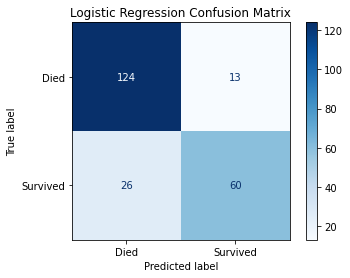

In [43]:
results_dict1 = fit_assess_model('Logistic Regression', log_reg, x_train, x_test, y_train, y_test)

Accuracy: 79.8206
[[118  19]
 [ 26  60]]


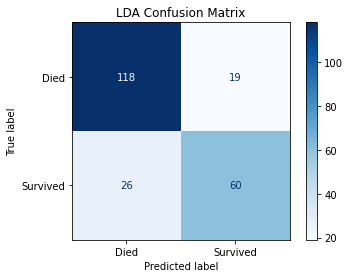

In [44]:
results_dict2 = fit_assess_model('LDA', LDA, x_train, x_test, y_train, y_test)

Accuracy: 80.2691
[[114  23]
 [ 21  65]]


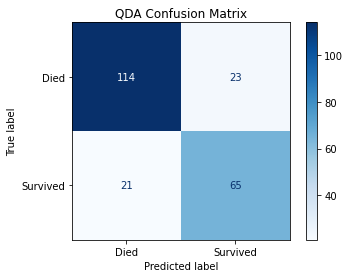

In [45]:
results_dict3 = fit_assess_model('QDA', QDA, x_train, x_test, y_train, y_test)

Accuracy: 85.6502
[[132   5]
 [ 27  59]]


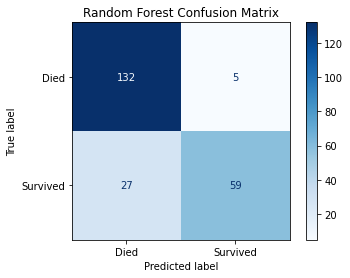

In [46]:
results_dict4 = fit_assess_model('Random Forest', rand_forest, x_train, x_test, y_train, y_test)

In [47]:
#end training and validation

## Review Model Results

The model results included accuracy, precision, and recall for each model.
 - Accuracy: (True Pos + True Neg)/(All)
 - Precision: (True Pos)/(True Pos + False Pos)
 - Recall: (True Pos)/(True Pos + False Neg)
 
 For this application, positive is represented as Survived:
 - Accuracy: (True Survived + True Died)/(All)
 - Precision: (True Survived)/(True Survived + False Survived)
 - Recall: (True Survived)/(True Survived + False Died)

In [48]:
#store results
model_dict = {}
model_dict["Logistic Regression"] = results_dict1 
model_dict["Linear Discriminant Analysis"] = results_dict2 
model_dict["Quadratic Discriminant Analysis"] = results_dict3
model_dict["Random Forest"] = results_dict4

In [49]:
#show results
show_results_table(model_dict)

                           Model  Accuracy  Precision  Recall
                   Random Forest    0.8565     0.9219  0.6860
             Logistic Regression    0.8251     0.8219  0.6977
 Quadratic Discriminant Analysis    0.8027     0.7386  0.7558
    Linear Discriminant Analysis    0.7982     0.7595  0.6977


All of these classifiers had good accuracy scores.  The precision scores were also good possibly due to data that included 62% negatives, potentially reducing the misclassification of negatives. Recall scores tended to be lower when compared to accuracy. Recall includes consideration of misclassifying survivers. These results may be related to the lower percentage of survivors in the data (38%). 

To better approximate model performance measures, a pipeline could be implemented to include all feature analysis and transformation steps. The partitioning of these step into a pipeline would allow for separate analysis of features for the training set, reducing the leakage of test observations into the feature selection process. Also, cross validation techniques could be applied with pipelining to hone performance measures further. 

This project shows the benefits of all four of these popular classification methods. In a future project, pipelining and K-fold cross validation could be used to hone the performance measures to aid model comparison.

In [ ]:
#end
#by Brenda Griffith 5/2021